In [37]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from glob import glob
from read_csv import read_csv

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [38]:
def get_span(df0):
    """
    Get span for cropping scan based on highest point (Z-data)
    within profile in the middle of scan. 
    Only works if there is one wall visible in the scan.

    Parameters
    ----------
    df0 : DataFrame
        data of first layer

    Returns
    -------
    span : range
        range of integers within the borders
    """

    # load z-data
    dfz = df0[int(2/3*len(df0.index)):].reset_index(drop=True)

    # one row of z data from middle of scan in xDir
    df_row = dfz.iloc[int(1/2*len(dfz.index)),:]

    # remove empty strings ''
    df_row = df_row.replace('', np.nan, regex=True).dropna()

    # restrict search for max(z) to middle of scan in yDir
    df_row = df_row[440:841] # middle = 640

    # get index of max(z)
    max_id = df_row.astype('float').idxmax(axis=0)

    # make fixed width arround highest point
    width = 200
    b0 = max_id - width # lower border
    b1 = max_id + width # upper border
    span = range(b0,b1+1) # +1 because range function behaves exclusive at upper border
    
    return span

In [39]:
def get_yMiddle(df0):
    """
    Get y-coordinate of zMax.
    Use this to correct the y-value of your point clouds.

    Parameters
    ----------
    df0 : DataFrame
        data of first layer

    Returns
    -------
    span : range
        range of integers within the borders
    """

    # load y-data & z-data
    dfy = df0[:int(1/3*len(df0.index))]
    dfz = df0[int(2/3*len(df0.index)):].reset_index(drop=True)

    # one row of data from the middle of scan (xDir)
    dfy_row = dfy.iloc[int(1/2*len(dfy.index)),:]
    dfz_row = dfz.iloc[int(1/2*len(dfz.index)),:]

    # remove empty strings ''
    dfy_row = dfy_row.replace('', np.nan, regex=True).dropna()
    dfz_row = dfz_row.replace('', np.nan, regex=True).dropna()

    # restrict search for max(z) to ROI arround 640 (1/2 of 1280 pixel)
    dfy_row = dfy_row[440:841]
    dfz_row = dfz_row[440:841]

    # get index of max(z)
    max_id = dfz_row.astype('float').idxmax(axis=0)
    y_zMax = float(dfy_row[max_id]) # y-value of zMax
    zMax = float(dfz_row[max_id])   # zMax

    return y_zMax

In [40]:
def df2float(df_in,n):
    """
    Replace empty strings with NaN and convert strings to float

    Parameters
    ----------
    df_in : DataFrame
        data from read_csv
    n : int
        drop rows with more than n NaN values

    Returns
    -------
    df : DataFrame
        dataFrame with NaN and values dtype = 'float'
    """

    # drop rows with more than n NaN values
    df = df_in.dropna(thresh=df_in.shape[1]-n)
    
    try:
        df = df.replace('', np.nan, regex=True) # replace empty string with NaN
    except:
        print('no NaN detected')
    finally:
        df = df.astype('float')
        df = df.reset_index()
    return df

In [41]:
def split_csv_2D(df):
    """
    Return the X,Y,Z as seperate arrays.

    Parameters
    ----------
    df : DataFrame
        data from read_csv

    Returns
    -------
    X2,Y2,Z2 : ndarray
        2D-arrays containing data of laserscan
    """

    r = len(df.index) # rows
    dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)
    
    X2 = dfx.to_numpy()[:,1:]
    Y2 = dfy.to_numpy()[:,1:]
    Z2 = dfz.to_numpy()[:,1:]

    return X2,Y2,Z2

In [42]:
def split_csv(df):
    """
    Return the X,Y,Z as seperate arrays.
    Delete NaN from arrays

    Parameters
    ----------
    df : DataFrame
        data from read_csv

    Returns
    -------
    X,Y,Z : ndarray
        1D-arrays containing data of laserscan
    """

    r = len(df.index) # rows
    dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)
    
    # convert to 2D numpy array
    X2 = dfx.to_numpy()[:,1:] # [:,1:] to ignore index col
    Y2 = dfy.to_numpy()[:,1:]
    Z2 = dfz.to_numpy()[:,1:]

    # make 1D array
    X,Y,Z = X2.flatten(),Y2.flatten(),Z2.flatten()

    # delete rows with NaN values
    mask = ~np.isnan(X)
    X,Y,Z = X[mask],Y[mask],Z[mask]

    # sort array for plot and np.gradient
    X,Y,Z = zip(*sorted(zip(X,Y,Z)))
    X,Y,Z = np.array(X),np.array(Y),np.array(Z)

    return X,Y,Z

In [43]:
def delete_outliers_yDir(X,Y,Z):
    """
    Delete outliers in yDir.
    Make straight edges.
    
    Parameters
    ----------
    X,Y,Z : ndarray
        1D arrays
    
    Returns
    -------
    X,Y,Z : ndarray
        1D arrays, no more outliers
    """
    # get unique x values
    ux = np.unique(X)
  
    # get min(y) and max(y) at each ux
    minY = []
    maxY = []
    for i in ux:
        y = Y[X==i] # get all y values at each unique x value
        minY.append(np.amin(y))
        maxY.append(np.amax(y))
    minY = np.array(minY)
    maxY = np.array(maxY)

    # get median(y) at edges
    y0 = np.median(minY) # low values
    y1 = np.median(maxY) # high values

    # delete rows which contain values above or below borders
    mask = ((Y > y0) & (Y < y1))
    X_out = X[mask]
    Y_out = Y[mask]
    Z_out = Z[mask]   
    return X_out,Y_out,Z_out

In [44]:
def scale_X_to_welding_speed(X,v_ScanControl,v):
    """
    Return the X-data with true coordinates.

    Parameters
    ----------
    X : ndarray
        1D or 2D array of X-Data generated by scanControl 3D-View
    v_ScanControl : float
        speed setting [mm/s] in scanControl 3D-View
    v : float
        true welding speed [mm/min]
    
    Returns
    -------
    X : ndarray
        2D array with corrected x data
    """

    f = v/(v_ScanControl*60) # [mm/s] --> [mm/min]
    X *= f
    return X

In [45]:
def get_zDiff(X,Y,Z,center,span):
    """
    Z-Data is not consistent between scans. 
    Therefore Z-Data must be adjusted for all scans to ensure overlapping. 
    Needed to enable merging points clouds for later analysis.
    
    Parameters
    ----------
    X,Y,Z : ndarray
        1D arrays of point cloud
    center : float
        x coordinate in the center of the ROI (region of interest)
    span : float
        span of the ROI, width = center +- span

    Returns
    -------
    zDiff : float
        average height in ROI (region of interest)
        intended use: set Z-data of base plate = 0
    """

    # crop to ROI in the middle of base plate
    x0,x1 = center - span, center + span
    mask = (X>x0) & (X<x1)
    X,Y,Z = X[mask],Y[mask],Z[mask]

    # get the index of the highest values of Y for each unique value in X
    indices = []
    for x in np.unique(X):
        # get the starting index of the sliced array
        slice_start = np.where(X == x)[0][0]
        # get the ending index of the sliced array
        slice_end = np.where(X == x)[0][-1] + 1
        # get the index of the max value
        max_index = np.argmax(Y[slice_start:slice_end]) + slice_start  
        indices.append(max_index)

    # get slice in xz-plane
    x = X[indices]
    z = Z[indices]

    # get median of z in ROI, height within ROI is defined as 0 for all scans
    zDiff = np.median(z)

    return zDiff

In [46]:
def get_xDiff(X,Y,Z,x_DropOff):
    """
    X coordinates of different scans do not overlap due to 
    manual starting/stopping of scans. At the end of each scan 
    is a sharp drop off at the end of the base plate. 
    The drop off is moved to x=x_DropOff
        
    Parameters
    ----------
    X,Y,Z : ndarray
        1D arrays
    x_DropOff : float
        desired x-coordinate of the drop off
    
    Returns
    -------
    xDiff: float
        distance of drop off in scan to xDropOff
    """

    # Define ROI containing the drop off  
    mask = (X>x_DropOff-40)
    X,Y,Z = X[mask],Y[mask],Z[mask]

    # get the index of the highest values of Y for each unique value in X
    indices = []
    for x in np.unique(X):
        # get the starting index of the sliced array
        slice_start = np.where(X == x)[0][0]
        # get the ending index of the sliced array
        slice_end = np.where(X == x)[0][-1] + 1
        # get the index of the max value
        max_index = np.argmax(Y[slice_start:slice_end]) + slice_start  
        indices.append(max_index)

    # slice in xz-plane
    x = X[indices]
    z = Z[indices]

    # get median of z in ROI
    z_med = np.median(z)
    
    # x value where z drop under the threshold
    threshold = 1
    try:
        idx = np.min(np.argwhere(z < z_med-threshold))-1 # drop point is at n-1
    except:
        idx = len(x)-1 # use last data point if no drop recorded

    # edit x-data to make scans overlap 
    xDiff = x[idx] - x_DropOff

    # ###################################
    # # plot profile with drop off      
    # fig = plt.figure(figsize=(3,3))
    # plt.scatter(x[idx],z[idx],marker='x',color='r') # drop point
    # plt.plot(x, z)  # slice
    # plt.xlabel('x')
    # plt.ylabel('z')
    # plt.xlim((180,220))
    # plt.show()

    return xDiff

In [47]:
def remove_baseplate(X,Y,Z,n,x_DropOff,dz):
    """
    Delete points of base plate. 

    Parameters
    ----------
    X,Y,Z : ndarray
        1D arrays
    n  : int
        number of slices from edges to be used for surface fit
    x_DropOff : float
        x-value of drop off (used to exclude drop off from surface fit)
    dz : float
        delta z, fitted surface will be raised by this value
        points below the fitted surface (e.g. the base plate) will be deleted

    Returns
    -------
    X_out,Y_out,Z_out : ndarray
        1D arrays without base plate points
    """
    
    # get the index of the 5 highest and 5 lowest values of Y for each unique value in X
    id = []
    n = 10 
    for x in np.unique(X):
        slice_start = np.where(X == x)[0][0]
        slice_end = np.where(X == x)[0][-1] + 1
        min_id = np.argpartition(Y[slice_start:slice_end], n)[:n] + slice_start  # get index of min n values
        max_id = np.argpartition(Y[slice_start:slice_end], -n)[-n:] + slice_start  # get index of max n values
        id.extend(np.concatenate((min_id, max_id)))

    # Get points on base plate
    x,y,z = X[id],Y[id],Z[id]

    # filter data: only x < xMax
    idx = x < x_DropOff-1 # xMax = x_DropOff -1
    x,y,z = x[idx],y[idx],z[idx]

    # filter data: delete outliers in zDir
    mask = (z < np.median(z) + 1) & (z > np.median(z) - 1) # only use median +-1
    x,y,z = x[mask],y[mask],z[mask]
    
    # Generate polynomial features up to degree 2
    poly = PolynomialFeatures(degree=2)
    xy_poly = poly.fit_transform(np.column_stack((x, y)))

    # Fit a linear regression model to the polynomial features
    model = LinearRegression()
    model.fit(xy_poly, z)

    # # Calculate the standard deviation of the original data to the fitted surface
    # Z_fit_baseplate = model.predict(xy_poly).reshape(x.shape)
    # std_dev = np.sqrt(np.mean((z - Z_fit_baseplate)**2))
    # print('standard deviation: ' + str(std_dev))

    #####################################################################
    # # Evaluate the fitted surface on a grid
    # minX,maxX,minY,maxY = np.amin(x),np.amax(x),np.amin(y),np.amax(y)
    # xFit, yFit = np.meshgrid(np.linspace(minX, maxX, 100), np.linspace(minY, maxY, 100))
    # x_test = poly.fit_transform(np.column_stack((xFit.ravel(), yFit.ravel())))
    # zFit = model.predict(x_test).reshape(xFit.shape) + dz

    # # Plot the data and the fitted surface
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x, y, z, c='b', marker='o')
    # ax.plot_surface(xFit, yFit, zFit, color='r', alpha=0.5)
    # plt.show()
    #####################################################################

    # Evaluate the fitted surface on the original data
    XY_poly = poly.fit_transform(np.column_stack((X, Y)))
    Z_fit = model.predict(XY_poly)

    # Delete all values of Z that are below the fitted surface (raised by dz)
    idz = Z > Z_fit + dz
    X_out,Y_out,Z_out = X[idz],Y[idz],Z[idz]   

    return X_out,Y_out,Z_out

In [48]:
def delete_outliers_zDir(X,Y,Z):
    """
    Delete outliers in zDir.
    
    Parameters
    ----------
    X,Y,Z : ndarray
        1D arrays
    
    Returns
    -------
    X,Y,Z : ndarray
        1D arrays, no more outliers
    """

    # get unique x values
    ux = np.unique(X)
  
    # get max(z) at each ux
    maxZ = []
    for i in ux:
        z = Z[X==i] # get all z values at each unique x value
        maxZ.append(np.amax(z))
    maxZ = np.array(maxZ)

    # erase outliers in z-Dir
    zBot = -1 # manual setting
    zMaxTop100 = np.partition(maxZ, -100)[-100:]
    zCei = np.median(zMaxTop100) + np.std(zMaxTop100)
    # print('ceiling = ' + str(zCei))

    # apply filter
    id = (Z>zBot) & (Z<zCei)
    X_out,Y_out,Z_out = X[id],Y[id],Z[id]

    return X_out,Y_out,Z_out

# import data

In [49]:
if __name__ ==  '__main__': 
    # get time for performance monitoring
    t0 = time.time()

    # set the folder path
    data_dir = r"T:\2023-02-13_Laserscans_mie-im\V05"

    # get list of CSV files
    csv_files = glob(os.path.join(data_dir, "*.csv"))

    # process the CSV files in parallel
    with Pool(processes=len(csv_files)) as pool:
      df_read = pool.map(read_csv, csv_files)

    # about 30-50 s depending on scan length
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

read finished after: 25.6 s


In [50]:
# Create a dictionary with index
file_index = {file_name: index for index, file_name in enumerate(csv_files)}

# get span for cropping dataFrames
span = get_span(df_read[0])

# get y-value of zMax in 1st layer
yMiddle = get_yMiddle(df_read[0])

# make dataFrame for writing proccesed data into
dfs = df_read.copy()

# preprocessing loop

01/15


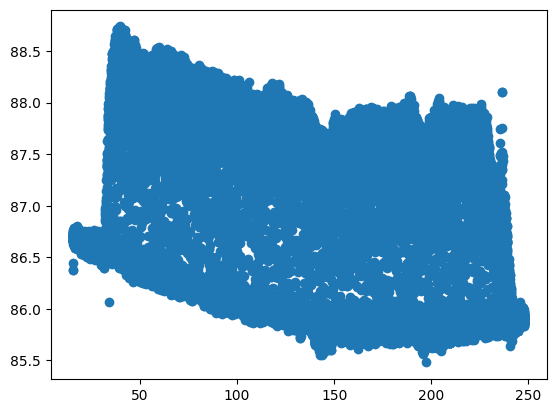

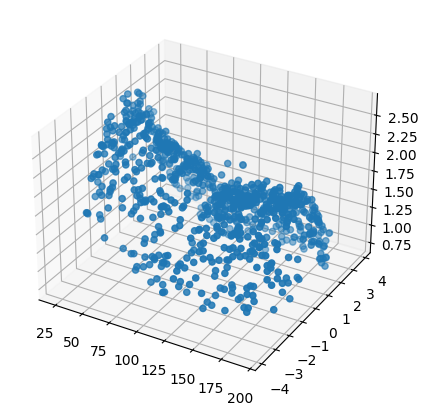

02/15


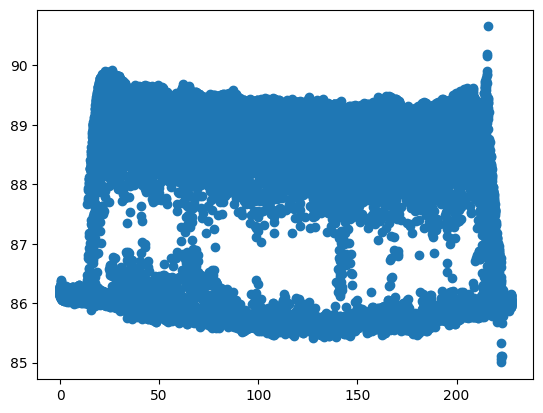

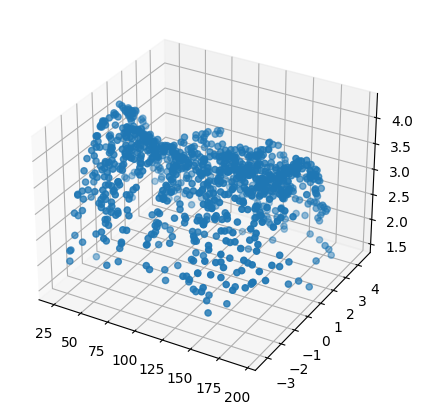

03/15


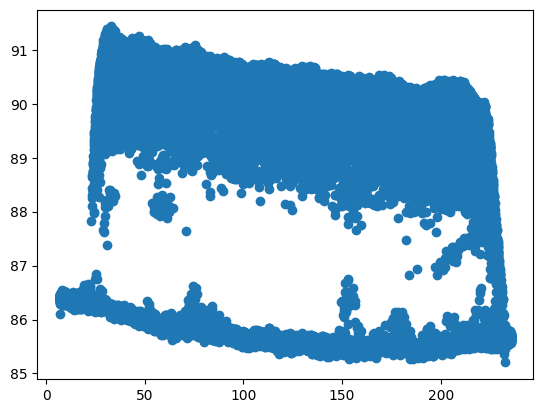

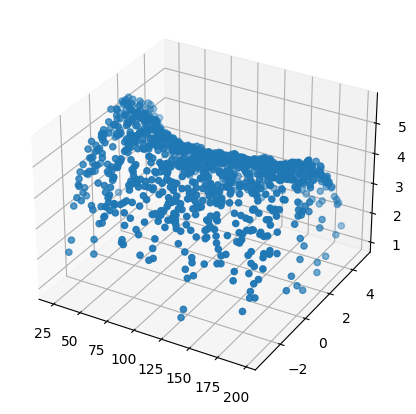

04/15


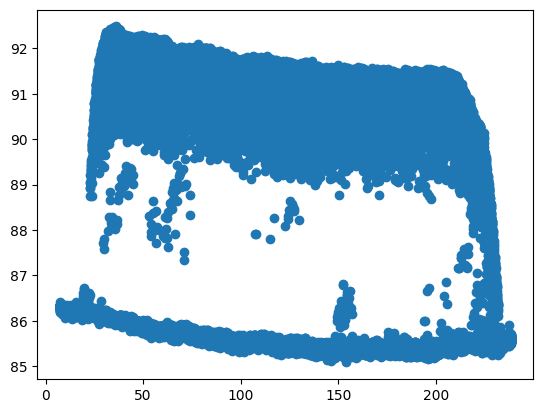

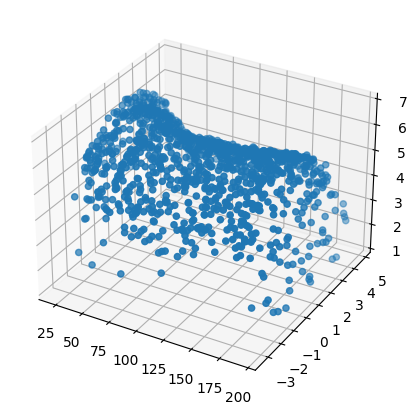

05/15


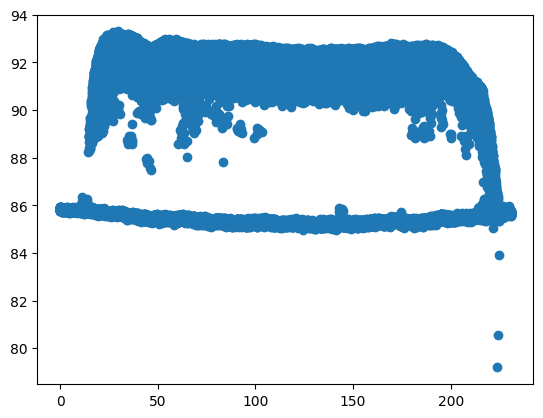

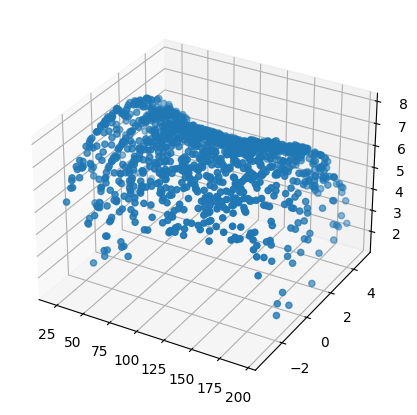

06/15


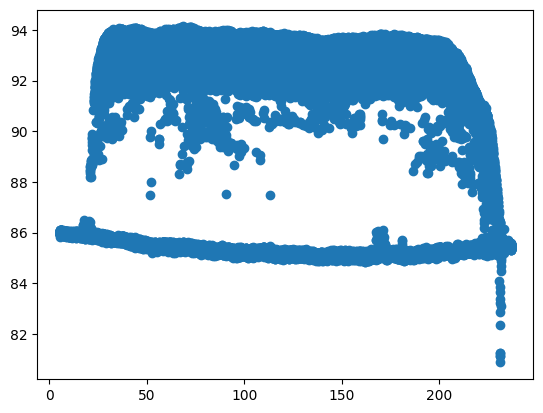

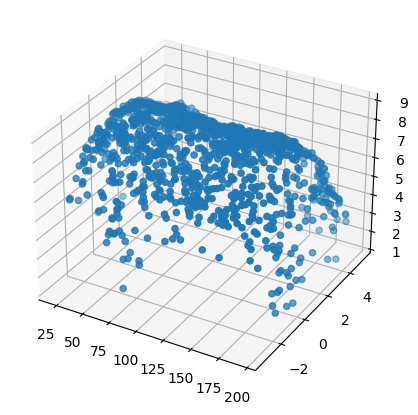

07/15


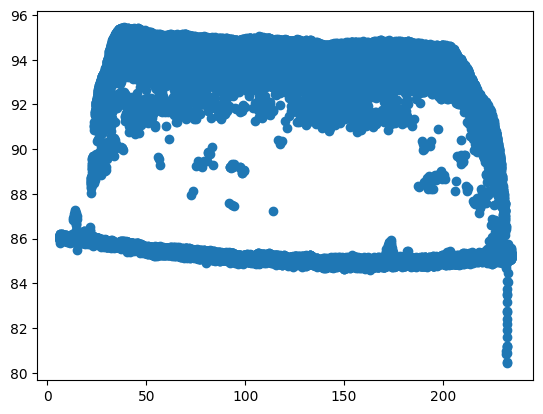

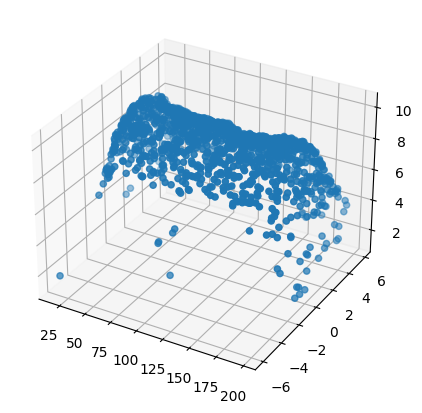

08/15


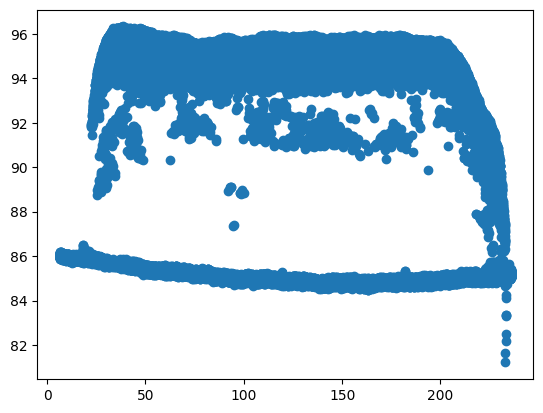

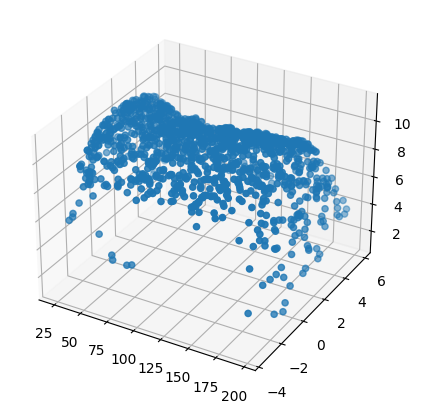

09/15


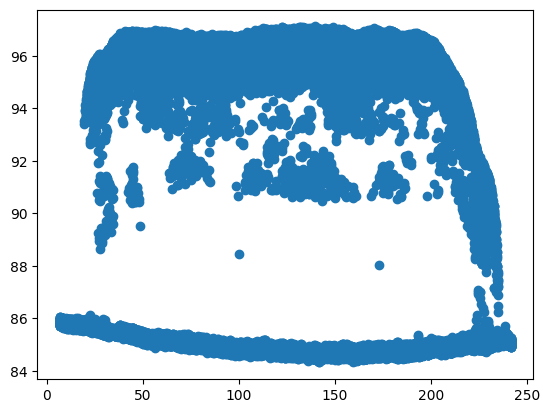

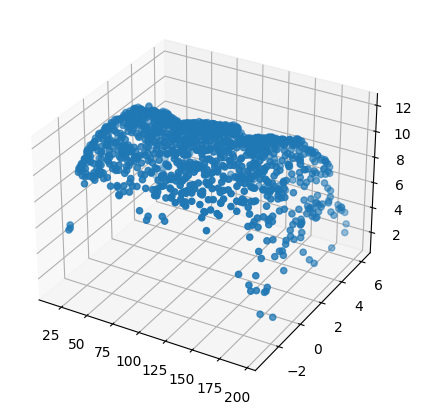

10/15


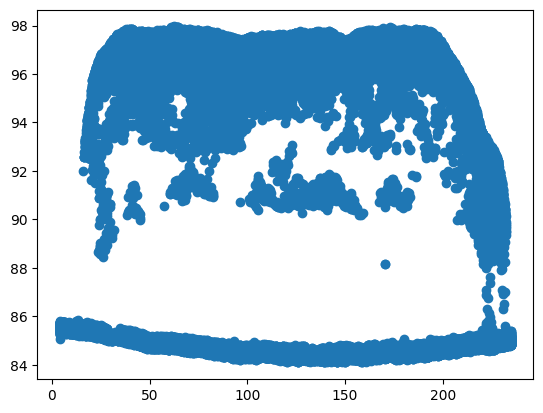

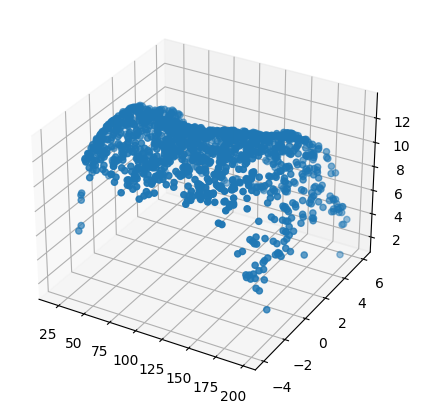

11/15


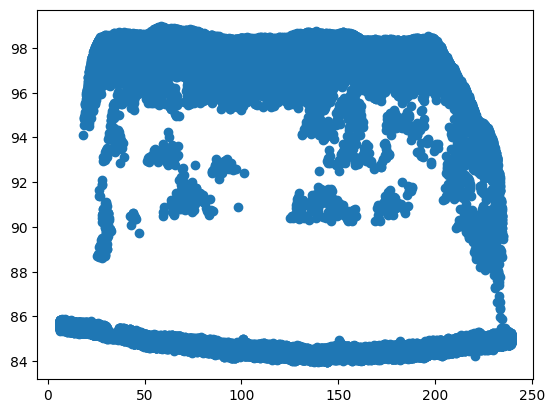

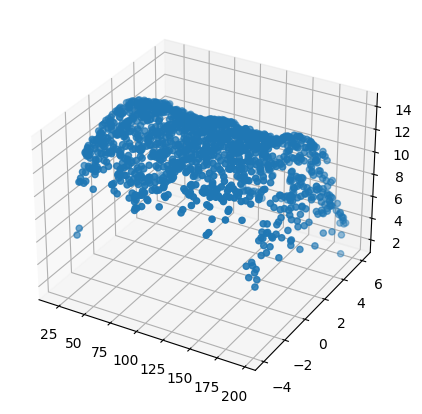

12/15


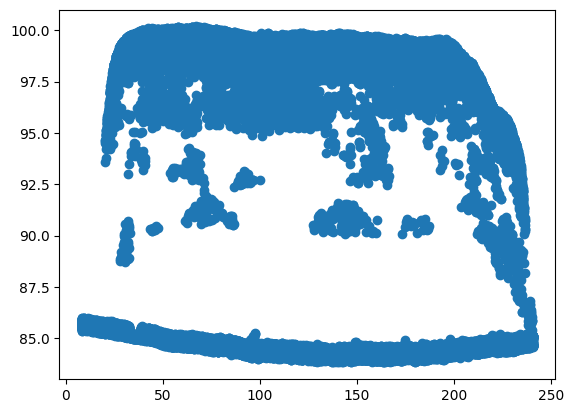

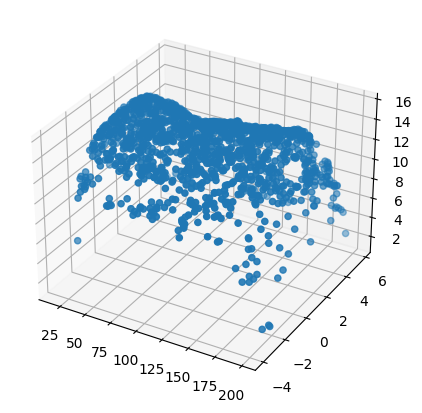

13/15


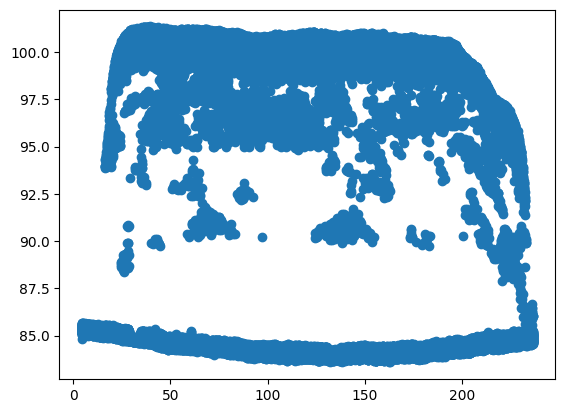

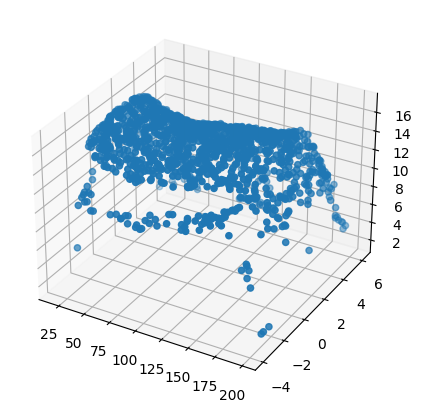

14/15


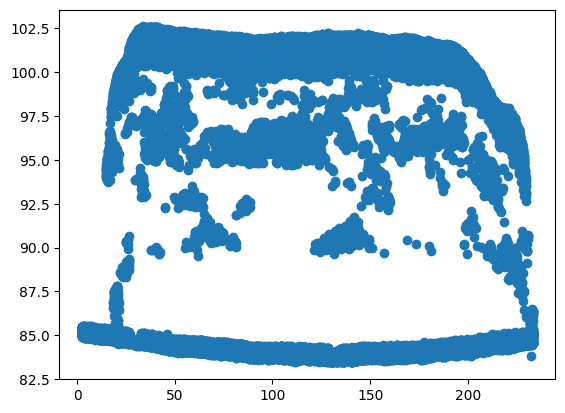

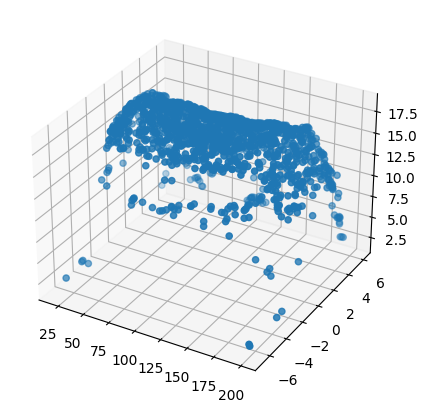

15/15


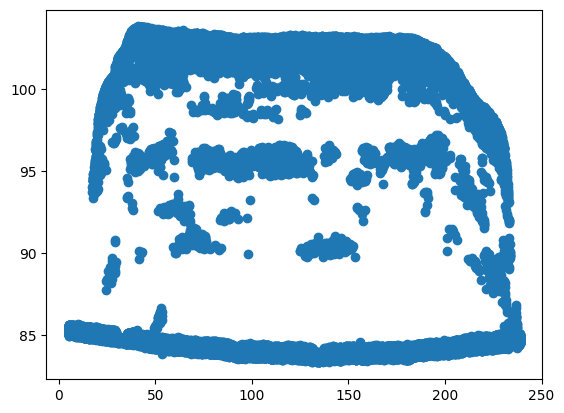

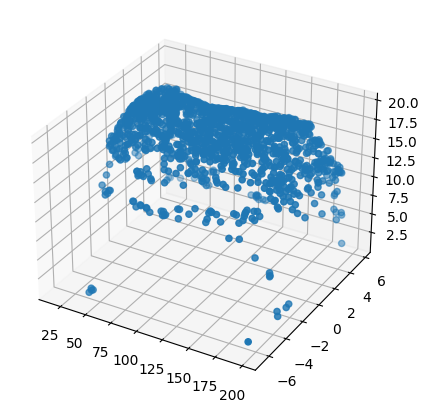

In [51]:
# loop through the files and preprocess them
for file_name in csv_files:
    # print progress
    print(file_name[-6:-4] + '/' + str(len(csv_files)))

    # 1.1 copy dataFrame
    df = df_read[file_index[file_name]].copy()

    # 1.2 drop columns outside of wall
    df = df.iloc[:,span]

    # 1.3 convert strings to float
    df = df2float(df,5)

    # 1.4 split csv into three arrays
    X,Y,Z = split_csv(df)

    # 1.5 delete outliers in yDir
    X,Y,Z = delete_outliers_yDir(X,Y,Z)

    # plot point cloud of layer
    dfp=pd.DataFrame({'X':X,'Y':Y,'Z':Z})
    dfp = dfp.sample(frac=0.1)
    fig, ax = plt.subplots()
    ax.scatter(dfp.X,dfp.Z)
    plt.show()

    # # plot point cloud of layer
    # dfp=pd.DataFrame({'X':X,'Y':Y,'Z':Z})
    # fig = plt.figure(figsize=(6,6))
    # ax = plt.subplot(projection='3d')
    # dfp = dfp.sample(frac=0.1)
    # ax.scatter(dfp.X,dfp.Y,dfp.Z)
    # ax.view_init(elev=0, azim=-90)
    # plt.show()

    # 1.6 scale x-axis based on actual welding speed
    v = [150,150,150,150,249,249,249,249,174,174,174,174,150,249,174,174,174] # V01...V15+V15R+V15VR
    i = int(data_dir[-2:])-1 # index of specimen in v
    X = scale_X_to_welding_speed(X,v_ScanControl=5,v=v[i])

    # 1.7 align data in x-dir and z-dir
    Z -= get_zDiff(X,Y,Z,center=100,span=10)
    xDropOff = 200
    X -= get_xDiff(X,Y,Z,xDropOff)

    # 1.8 remove base plate
    if file_name == glob(os.path.join(data_dir, "*layer01.csv")):
        X,Y,Z = remove_baseplate(X,Y,Z,n=10,x_DropOff=xDropOff,dz=0.2) # tolerance for 1st layer
    else:
        X,Y,Z = remove_baseplate(X,Y,Z,n=10,x_DropOff=xDropOff,dz=1)

    # 1.9 crop data + delete outliers
    X,Y,Z = delete_outliers_zDir(X,Y,Z)
    
    # 1.10 move point cloud
    Y = Y-yMiddle # top of 1st layer --> y=0

    # 1.11 append to dataFrame of all scans
    dfn = pd.DataFrame({'X':X,'Y':Y,'Z':Z})
    dfs[file_index[file_name]] = dfn   

    ##################################################
    # 1.12 plot final point cloud
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(projection='3d')
    dfn = dfn.sample(frac=0.01)
    ax.scatter(dfn.X,dfn.Y,dfn.Z)
    ax.view_init(elev=30, azim=-60)
    plt.show()

# end of for-loop
# 15 files: 180 s

In [52]:
# 2.0 save arrays
import fastparquet

for file_name in csv_files:
    # decider for single or double digit filename
    if file_index[file_name]+1 < 10:
        filepath = data_dir + '\layer_0' + str(file_index[file_name]+1) + '.parquet'
    else:
        filepath = data_dir + '\layer_' + str(file_index[file_name]+1) + '.parquet'

    # save as parquet
    dfs[file_index[file_name]].to_parquet(filepath)
    